# Part 2: solving position ambiguity and reconstructing the correct trajectories

In [1]:
import numpy as np 
import pandas as pd 
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import linregress
from itertools import product 

First we pick up where we left off by loading the preprocessed dataset with the time pedestals and the drift times already computed in parts 0 & 1.

In [2]:
dataset = pd.read_csv("dati_MM1.csv") #notice: this no longer contains the triggers, which stop being useful the moment we compute the time pedestals.
display(dataset)

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL,DRIFT_TIME,X,COLUMN
0,13.0,1897417007,445.0,24.0,11145.000000,3.0,4.0,1.0,11350.0,205.000000,11.038462,4
1,14.0,1897417007,450.0,9.0,11257.500000,3.0,2.0,1.0,11350.0,92.500000,4.980769,4
2,16.0,1897417007,452.0,17.0,11314.166667,3.0,1.0,1.0,11350.0,35.833333,1.929487,4
3,15.0,1897417007,458.0,9.0,11457.500000,3.0,3.0,1.0,11350.0,107.500000,5.788462,4
4,89.0,1897417267,300.0,27.0,7522.500000,2.0,4.0,1.0,7825.0,302.500000,16.288462,7
...,...,...,...,...,...,...,...,...,...,...,...,...
114051,19.0,1920940163,1449.0,2.0,36226.666667,3.0,3.0,1.0,36075.0,151.666667,8.166667,5
114052,55.0,1920940194,325.0,4.0,8128.333333,3.0,3.0,1.0,8225.0,96.666667,5.205128,14
114053,56.0,1920940194,327.0,22.0,8193.333333,3.0,1.0,1.0,8225.0,31.666667,1.705128,14
114054,54.0,1920940194,331.0,20.0,8291.666667,3.0,2.0,1.0,8225.0,66.666667,3.589744,14


## Computing XR & XL
Our dataframe contains the columns `X`, `COLUMN` and `LAYER`, where for each given hit:
- `X` represents the distance between where the hit took place and the center of the corresponding cell;
- `COLUMN` represents the horizontal position of the center of the aforementioned cell in $\Delta x/2$ units, i.e. it's the number we obtain if we count cells starting from the leftmost one in that particular layer;
- `LAYER` is the vertical position of the center of the cell in $\Delta y/2$ units, i.e. the number we obtain if we count cells starting from the bottommost one in that particular column.    

We can define the new columns `XR` and `XL` as the columns containing the positions of the two possible hit locations for each given hit. We define `XR` and `XL` differently from `X`; namely, we require that `XR` and `XL` be measured in mm starting from the origin of our coordinate system (i.e. the bottommost, leftmost point of the detector). It's clear, therefore, that in order to compute these two columns we need to use the following formulae:
$$\text{XR} = \Delta x\cdot \left(\text{COLUMN}+f(\text{LAYER})\right)  + \text{X} $$
$$\text{XL} = \Delta x\cdot \left(\text{COLUMN}+f(\text{LAYER})\right)  - \text{X}$$
where $f(\text{LAYER})$ is $-1/2$ if LAYER is odd, 0 otherwise. The reason for this is the following: if XC is the position of the center of the cell in mm wrt the origin of our coordinate system (as defined above) then XL and XR are just XC-X and XC+X respectively; therefore we only need to find a general formula for XC.  
In our convention layer 1 is the bottommost; therefore layers 2 and 4 are shifted by $\Delta x/2$ to the right wrt layer 1 and 3. If we consider one of the odd layers we see that the absolute position of each cell center is $\Delta x/2$, $3\Delta x/2$, $5\Delta x/2$,... ; this means that XC can be computed as $(\Delta x/2) \cdot (2\cdot \text{COLUMN}-1)=\Delta x \cdot(\text{COLUMN}-1/2)$. Even layers are shifted to the right, therefore we need to add $+\Delta x/2$; this cancels the $-1/2$ inside the parentheses; the same result can be obtained by considering that due to this horizontal $\Delta x/2$ shift the cell centers in layers 2 & 4 have absolute positions given by $\Delta x$, $2\Delta x$, $3\Delta x$,..., i.e. $\Delta x\cdot \text{COLUMN}$.  
A trivial application of these equations yields the `XR` and `XL` columns we're looking for.

### Discarding and adding columns
In order to compute `XR`, `XL` according to the previous cell we explicitly need to keep the `X`, `COLUMN` and `LAYER` columns; we also need to keep `ORBIT_CNT` and `EVENT` so that we can identify which events each hit belongs to. We also initialize the new columns by filling them with `NaN`'s.

In [3]:
df = dataset.copy() #useful to debug without reloading the dataset
df = df[["ORBIT_CNT","LAYER","EVENT","X","COLUMN"]] #we only keep this list of columns
df["XR"] = np.nan
df["XL"] = np.nan
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL
0,1897417007,4.0,1.0,11.038462,4,NaN,NaN
1,1897417007,2.0,1.0,4.980769,4,NaN,NaN
2,1897417007,1.0,1.0,1.929487,4,NaN,NaN
3,1897417007,3.0,1.0,5.788462,4,NaN,NaN
4,1897417267,4.0,1.0,16.288462,7,NaN,NaN
...,...,...,...,...,...,...,...
114051,1920940163,3.0,1.0,8.166667,5,NaN,NaN
114052,1920940194,3.0,1.0,5.205128,14,NaN,NaN
114053,1920940194,1.0,1.0,1.705128,14,NaN,NaN
114054,1920940194,2.0,1.0,3.589744,14,NaN,NaN


### Actual `XL` and `XR` computation
If we group our dataframe by `ORBIT_CNT`, `EVENT` *and* `LAYER` each group will contain a single hit; this is true because we already discarded events with multiple hits per layer in part 0. This makes it easy to access the `X`, `COLUMN` and `LAYER` values for each given hit; by checking whether `LAYER` is odd or even we can apply one of the previous equations.  
Notice that the code that does this is "recycled" from part 1's drawing function; there `XR` and `XL` were actually already computed in order to draw some events - it's just that the results were not saved, and instead only used to plot points.

In [4]:
def compute_xr_xl(hit) :
    dx = 42 #each rectangular cell is 42 mm long. dx stands for \Delta x, and is used to scale units - useful to switch from "relative" to "absolute" units.

    #here it's better to cast a pandas series as a numpy array; otherwise this vectorized operation has issues
    if hit.LAYER.to_numpy(dtype=int) % 2 != 0 : #odd layer --> no horizontal shift
            hit["XR"] = dx * (hit.COLUMN - 1/2) + hit.X #XC + X
            hit["XL"] = dx * (hit.COLUMN - 1/2) - hit.X #XC - X
    else :
        hit["XR"] = dx * hit.COLUMN + hit.X #even layers --> by summing an extra dx/2 term that -1/2 disappears 
        hit["XL"] = dx * hit.COLUMN - hit.X 
    return hit

df = df.groupby(["ORBIT_CNT","EVENT","LAYER"],group_keys=False).apply(compute_xr_xl) #this groupby is restrictive enough that it lets us apply compute_xr_xl on a per-hit basis
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL
0,1897417007,4.0,1.0,11.038462,4,179.038462,156.961538
1,1897417007,2.0,1.0,4.980769,4,172.980769,163.019231
2,1897417007,1.0,1.0,1.929487,4,148.929487,145.070513
3,1897417007,3.0,1.0,5.788462,4,152.788462,141.211538
4,1897417267,4.0,1.0,16.288462,7,310.288462,277.711538
...,...,...,...,...,...,...,...
114051,1920940163,3.0,1.0,8.166667,5,197.166667,180.833333
114052,1920940194,3.0,1.0,5.205128,14,572.205128,561.794872
114053,1920940194,1.0,1.0,1.705128,14,568.705128,565.294872
114054,1920940194,2.0,1.0,3.589744,14,591.589744,584.410256


## Computing the `Y` column
Later we'll need the complete coordinates of each candidate point (both for plotting and fitting reasons); this means that not only `XR`/`XL` is required, but `Y` too. Once again recycling code from part 1 lets us easily compute this column as a function of `LAYER`; we simply need to observe that the first layer has a center with $y=\Delta y/2$, the second one has  $y=3\Delta y/2$, then we have $y=5\Delta y/2$ and $y=7\Delta y/2$ - which can all be computed as 
$$\text{Y} = \Delta y \cdot \left(\text{LAYER} - \frac{1}{2} \right) $$

In [5]:
dy = 13 #height of a single rectangular cell in mm
df["Y"] = dy * (df.LAYER-1/2)
display(df)

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y
0,1897417007,4.0,1.0,11.038462,4,179.038462,156.961538,45.5
1,1897417007,2.0,1.0,4.980769,4,172.980769,163.019231,19.5
2,1897417007,1.0,1.0,1.929487,4,148.929487,145.070513,6.5
3,1897417007,3.0,1.0,5.788462,4,152.788462,141.211538,32.5
4,1897417267,4.0,1.0,16.288462,7,310.288462,277.711538,45.5
...,...,...,...,...,...,...,...,...
114051,1920940163,3.0,1.0,8.166667,5,197.166667,180.833333,32.5
114052,1920940194,3.0,1.0,5.205128,14,572.205128,561.794872,32.5
114053,1920940194,1.0,1.0,1.705128,14,568.705128,565.294872,6.5
114054,1920940194,2.0,1.0,3.589744,14,591.589744,584.410256,19.5


## Solving the XR/XL ambiguity
### Constructing all combinations & designing the score function    

Let's say that a certain event is made up from 4 hits. Each of these hits has one value for `XR` and another for `XL`; by picking one of these for each of the 4 hits we can create $2^4=16$ different combinations of 4-tuples, where the $i$-th element is either $\text{XR}_i$ or $\text{XL}_i$. It's clear therefore that in order to solve the ambiguity we need to do the following:  
1) systematically assemble each possible $n$-tuple of X's for each given event; this amounts to computing the *cartesian product* set $S = [\text{XR}_1,\text{XL}_1]\times...\times[\text{XR}_n,\text{XL}_n]$.      
2) figure out a strategy that lets us pick the best tuple according to a predefined schema; the best tuple will contain either XR or XL for each hit (but not both), therefore ruling out the ambiguity and telling us which one to pick.   
- Point 1) is actually simple enough to achieve; we can use the `itertools.product()` built-in python function, which is a fast (C-based) implementation of the cartesian product of its arguments. By using `.loc[]` and `.to_numpy()` it's easy to create an array with all the $\text{XR}_i$/$\text{XL}_i$, which can be unpacked with the *unpack operator* * and fed to `itertools.product()`. The result is an iterable which we cast to `list` first, and to `numpy.array` later. The result is a matrix such that each row is one combination and each column one of the layers (i.e. one of the values of $i$). This whole operation is both very fast (due to the heavy optimizations baked in `itertools.product()`) and simple and compact (it's a one-liner).    
- Point 2) can be adressed in multiple ways; we choose to design a least-squares method inspired "score function" to rate each combination as follows.    

Each row of the aforementioned matrix represent one possible combination, which in turn determines one possible straight line (whose parameters we'll determine later on); which line is the best one? In order to solve this issue we first observe that due to experimental error no line actually crosses more than 2 points, so we need to consider linear regression if we are to compute any one trajectory. We may therefore compute the 2 coefficients $m, \ q$ of the best fit line associated to each combination, use these to compute the $\chi^2$ and pick the line (i.e. tuple $T\in S$) which minimizes the $\chi^2$; the idea is that the best line should be the one closest to crossing its points, i.e. the one which minimizes the average difference between the observed $x_i$ and the expected $\mathbb{E}(x_i)=(y_i-q)/m$ - and therefore $\chi^2$.  
This approach is conceptually simple, but relatively hard and expensive to implement even ignoring numerical conditioning issues (which we'll touch upon later); therefore we proceed as follows.   
Instead of computing $m$ and $q$ for each row of the combinations matrix (which is wasteful, since only one line will be saved) we compute the slope $m$ associated to the line crossing any pair of points in each combination; this requires computing $m_{ij}=\Delta y_{ij}/\Delta x_{ij} = (y_i-y_j)/(x_i-x_j)$. Each one of the $m_{ij}$ can wildly differ; we therefore declare the best line as the one that minimizes the variation in $m_{ij}$ (because then this line will be the closest at passing through its points). If we can compute an array containing all possible differences of $m_{ij}$'s we can use its norm (i.e. the sum of squares of the kind $(m_{ij}-m_{kl})^2$) as a score to be minimized, and this solves our problem in a way that is reminiscent of the least squares method.   
This approach, though, can still be improved by reducing the number of $m_{ij}$'s we need to compute (which is relatively large) as follows. Instead of assembling each possible pair of points and each possible difference of pairs of $m_{ij}$ values (using `itertools.combinations()`, for example) we can sort points by `LAYER` (i.e. by $y_i$) and only work with **pairs of spatially consecutive points**.      

- *Why consecutive points?* Imagine we have 3 points perfectly aligned and the 4th one very far from where it should be in order to lay on the same line. If we pick every possible pair of points then most of them will result in the same $m$, and therefore almost all components in the final $[m_{ij}-m_{kl}]$ vector will be zero. Depending on how far the 4th point is the final score may be relatively low even if a configuration with all 4 points very slightly perturbed should be preferred. Of course this choice is at least in part arbitrary, and there certainly may be situations where multiple possible trajectories are close; the true reason because this score function is a good choice is that it's *much simpler* to implement and compute, and the above reasoning shows why at least in limiting cases it may be preferable wrt the "vanilla" implementation outlined above.
- *Why spatially consecutive points?* It's easy to convince ourselves that if we compute the desired score vector as a difference vector between $m_{ij}$'s then the result will depend on the ordering of the $m$'s inside the array - which is something we can't control without sorting by `LAYER` (and hence $y$) value. Not only does this remove this arbitrariness in the computation of the score, but it also makes more sense according to the previous bullet point - i.e. that it's both simple and reasonable to compute differences relative to adjacent points in *space*, not just *in the dataframe*. Due to this reasons we use a `.sort_values()` before applying our custom function.         

To recap: after computing each possible tuple $T\in S$ we set the best tuple (i.e. the one that leads to the line with the highest chance at being physical) as 
$$\hat{T} = \mathrm{argmin}_{T\in S} \ \text{score}(T) $$ 
where the score function computes the L2 norm of the vector of the differences between the $\Delta y/\Delta x$'s we can compute considering consecutive elements in the `x` and `y` arrays (i.e. the difference vectors). Do note that other choices are possible (for example the L1 norm); the L2 norm is our default choice because it can be efficiently computed via `numpy.linalg.norm()` and because if compared to the L1 norm it more strongly penalizes few large errors (instead of many small ones). 

Note: other solutions may be possible; for example one may use a different algorithm (e.g. we may use $\chi^2$ in point 2) or a different implementation of the same algorithm (we'll see an approach based on `numba` in part 3). Here we're simply stating that this solution strikes a good compromise between conceptual/technical simplicity and being complex enough to actually work.    
  
### Numerical conditioning of the score function
Due to the nature of the experimental setup many constructed lines will be almost vertical, and as such the value of some of the $\Delta y/\Delta x$ may be very high - so high that it dominates the norm and that it leads to loss of information. This actually does happen if we define the score function as above, and leads to wrong results; removing these large values via a "renormalization" fixes the problem.
- One possible strategy is to use the angle $\alpha=\arctan m$ instead of $m$ itself as the quantity that shouldn't change very much if we vary the couple of points used it to compute it. This has a nice geometrical interpretation (we're trading the slope with the angle wrt the $x$ axis, which is always finite), and can clearly fix our problem because the arctangent function itself has a similar shape to the sigmoid/hyperbolic tangent functions used in ML to normalize values varying over a large interval; the disadvantage to this approach is that the arctangent is expensive to compute.
- A second approach is to invert the $x$ and $y$ variables; this geometrically corresponds to an orthogonal reflection wrt the line $y=x$, and turns almost vertical lines in almost horizontal lines - whereas lines close to $y=x$ keep that property. Mathematically speaking the score function doesn't change under this transformation (since it only looks for lines such that $m$ doesn't change if we vary the pair of points *irrespective of whichever value it has*), but in practice this makes our algorithm behave much better since it ensures that $|m|$ is approximately between 0 and 1.      

Combining what was said in these 2 subsections easily explains the next cell.


In [6]:
def score(x,y): #score function
    dx = np.diff(x) #array with the delta's associated to spatially consecutive points
    dy = np.diff(y) 
    slope = dx/dy #np.arctan(dx/dy) or np.arctan(dy/dx) are possible equivalent alternatives
    sc = np.linalg.norm(np.diff(slope)) #sum of squares of differences between m's computed with consecutive pairs
    return sc

def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['XR','XL']].to_numpy()))) #matrix s.t. each row is one possible combination
    if combin.shape[1] != event.Y.shape[0] : #sanity check
        print("X.shape and Y.shape don't match")
        return None 
    s = np.zeros(combin.shape[0]) 
    for i in range(combin.shape[0]) :
        s[i] = score(combin[i],event.Y.to_numpy()) #score computation for each combination
    event['X_BEST'] = combin[s.argmin()]
    return event

In [7]:
df1 = df.sort_values(['ORBIT_CNT', 'EVENT','LAYER'])
df1 = df1.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(solve_ambiguity)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
df1

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST
0,1897417007,1.0,1.0,1.929487,4,148.929487,145.070513,6.5,148.929487
1,1897417007,2.0,1.0,4.980769,4,172.980769,163.019231,19.5,163.019231
2,1897417007,3.0,1.0,5.788462,4,152.788462,141.211538,32.5,152.788462
3,1897417007,4.0,1.0,11.038462,4,179.038462,156.961538,45.5,156.961538
4,1897417267,1.0,1.0,13.012821,7,286.012821,259.987179,6.5,286.012821
...,...,...,...,...,...,...,...,...,...
114051,1920940163,4.0,1.0,3.589744,5,213.589744,206.410256,45.5,206.410256
114052,1920940194,1.0,1.0,1.705128,14,568.705128,565.294872,6.5,568.705128
114053,1920940194,2.0,1.0,3.589744,14,591.589744,584.410256,19.5,584.410256
114054,1920940194,3.0,1.0,5.205128,14,572.205128,561.794872,32.5,572.205128


## Finally computing the trajectory
### Linear regression
The above procedure lets us pick one combination of X's such that a unique line can be computed as a result. Let's say the equation of this line is 
$$y=mx+q$$
where $m$, $q$ uniquely identify this line; if our line exactly crossed our data points then we may obtain $m$ and $q$ by demanding that each $(x_i,y_i)$ be a solution of the above equation, but since experimental error makes this approach fail every time we compute $m$ and $q$ using *linear regression*.    
A large variety of functions may be used to perform such computation; we pick `scipy.stats.linregress()` for the following reasons:
- it's one of the fastest (cfr [this](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/)), being written in C and in such a way as to be very specific (more general functions are slower as a result);
- it's one of the simplest to use. For example `numpy.linalg.lstsq()` may sometimes offer slightly better performance, but since it requires us to use homogeneous coordinates we'd need to use `numpy.hstack()` with `numpy.ones()` *before* actually passing `X_BEST` and `Y`, resulting therefore in a more complicated implementation which does extra computations (which at least in part neglect the performance gain we'd be looking for). Similar things may be said about manually solving the least squares problem with `numpy.linalg.inv()`: this would require us to carry on some matrix sums/products  to build the arrays we'd need to pass on to `numpy.linalg.inv()`. Since the following cell is already fast enough there's no point in spending time working to implement more complex stuff that may yield a negligible performance gain (this will be a recurring theme in part 3).    
We therefore compute columns `M` and `Q` using `scipy.stats.linregress()`; for simplicity's sake we assign the computed values for $m$ and $q$ to each point corresponding to that particular line.

### Numerical conditioning of the linear regression 
In practice the computation of $m$ and $q$ may easily give extremely wrong results - even when we found the correct combination of points. This is a consequence of the fact that $m$ is not well defined for almost vertical lines. Once again we can employ the "inversion strategy", where we switch $x$ and $y$ i.e. we perform an orthogonal reflection wrt $y=x$. This (as explained above) makes $m$ behave much better, but gives us the wrong line; in order to fix this we perform another inversion of variables (which geometrically gives us the correct line since a double reflection is the identity transformation).   
In practice what we need to do is the following: we perform the linear regression with x and y in place of each other, and then we consider that if $y=ax+b$ then $x=(y-b)/a$ - and therefore if $m$ and $q$ are the "wrong" coefficients obtained via `linregress` it's enough to recompute them as:
$$q' = -\frac{q}{m} $$
$$m' = \frac{1}{m} $$
since this is equivalent to switching $x$ and $y$ once again in the "inverse line" $x=(y-b)/a$.

In [8]:
# M & Q columns computation. These represent the slope and the intercept (respectively) of our trajectory
def mq(event):
    res = linregress(y=event['X_BEST'].to_numpy(),x=event['Y'].to_numpy()) #variable inversion
    event['M'] = res.slope
    event['Q'] = res.intercept
    return event

In [9]:
df2 = df1.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(mq)\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
df2["Q"] = -df2["Q"]/df2["M"]
df2["M"] = 1/df2["M"]
df2

,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST,M,Q
0,1897417007,1.0,1.0,1.929487,4,148.929487,145.070513,6.5,148.929487,9.375867,-1431.241100
1,1897417007,2.0,1.0,4.980769,4,172.980769,163.019231,19.5,163.019231,9.375867,-1431.241100
2,1897417007,3.0,1.0,5.788462,4,152.788462,141.211538,32.5,152.788462,9.375867,-1431.241100
3,1897417007,4.0,1.0,11.038462,4,179.038462,156.961538,45.5,156.961538,9.375867,-1431.241100
4,1897417267,1.0,1.0,13.012821,7,286.012821,259.987179,6.5,286.012821,-3.477963,1005.018607
...,...,...,...,...,...,...,...,...,...,...,...
114051,1920940163,4.0,1.0,3.589744,5,213.589744,206.410256,45.5,206.410256,7.031900,-1394.060680
114052,1920940194,1.0,1.0,1.705128,14,568.705128,565.294872,6.5,568.705128,5.539470,-3167.389101
114053,1920940194,2.0,1.0,3.589744,14,591.589744,584.410256,19.5,584.410256,5.539470,-3167.389101
114054,1920940194,3.0,1.0,5.205128,14,572.205128,561.794872,32.5,572.205128,5.539470,-3167.389101


## Drawing reconstructed trajectories
Here we recycle code from part 0/part 1. The only difference is that we use columns `M` and `Q` to plot the straight line corresponding to our reconstructed trajectory, and that we underline the point corresponding to `X_BEST` (i.e. to the winner between `XR` and `XL` on a per-hit basis).

In [10]:
# TRAJECTORY PLOT

delta_x = 42/(2*390)*(50) #uncertainty over x = v_drift*delta_t=42/(2*390)*(2*25).

def event_and_line_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of one cell
    dx = 42
    dy = 13
    
    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)

    #we introduce extra, unneeded variables to make everything easier to read
    xr = event['XR'].to_numpy()
    xl = event['XL'].to_numpy()
    X = event['X_BEST'].to_numpy()
    Y = event['Y'].to_numpy()

    x_1 = x_3 = np.arange(16)*dx 
    x_2 = x_4 = x_1 + dx/2
    [y_1, y_2, y_3, y_4] = np.arange(4)*dy 


    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(xr,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.scatter(xl,Y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    ax1.errorbar(X, Y, xerr=delta_x, fmt='.', c = 'blue', linewidth = 7) # errorbar
    ax1.plot([(-2-event.Q)/event.M,(60-event.Q)/event.M] ,[-2,60], c = 'blue', linewidth = 7) #we plot a line segment with extremes corresponding to y=-2 and y=60 respectively (this suffices since the detector roughly is in the [0,50] interval).
    return ax1

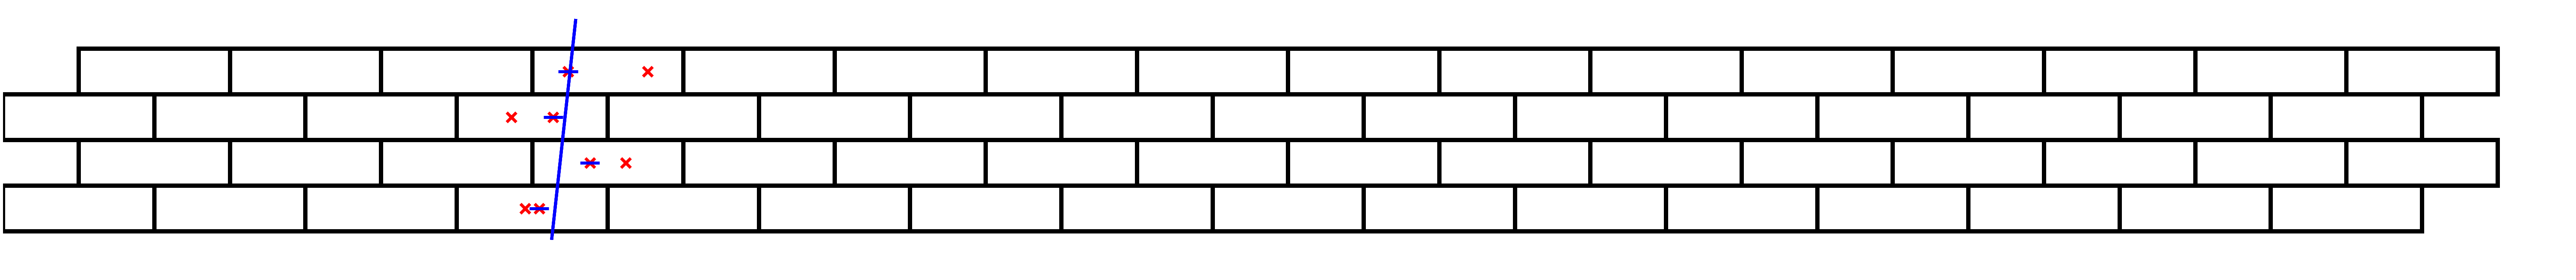

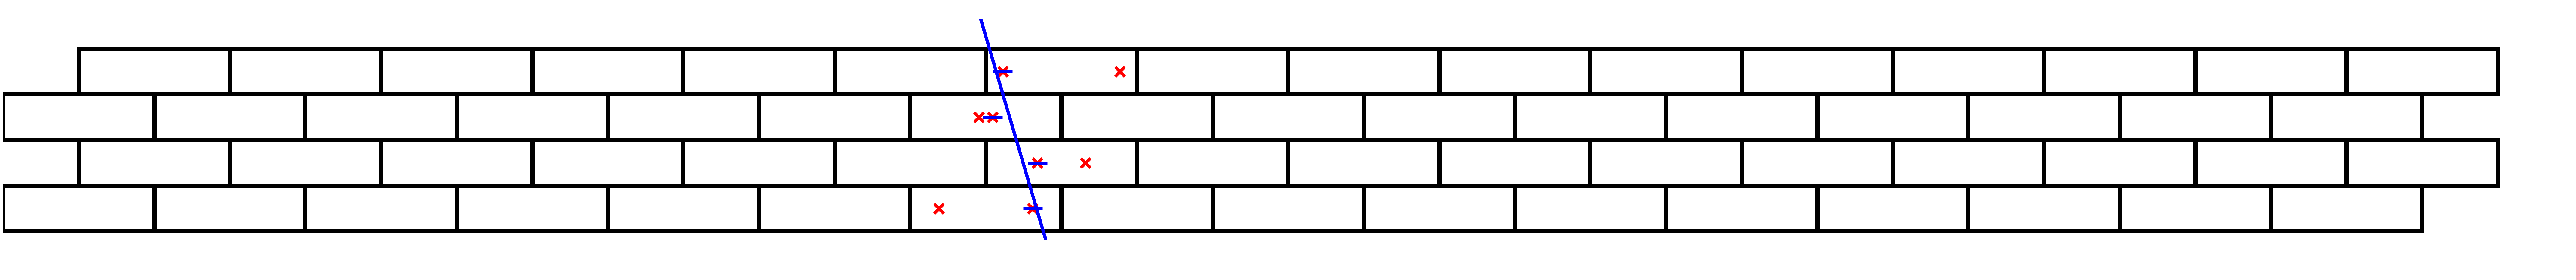

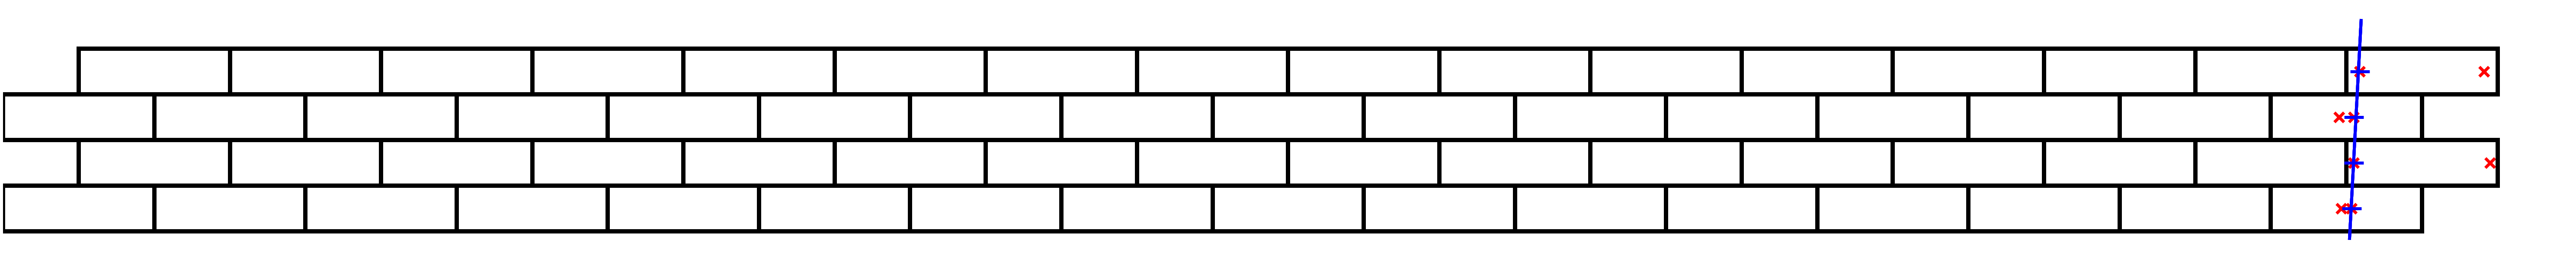

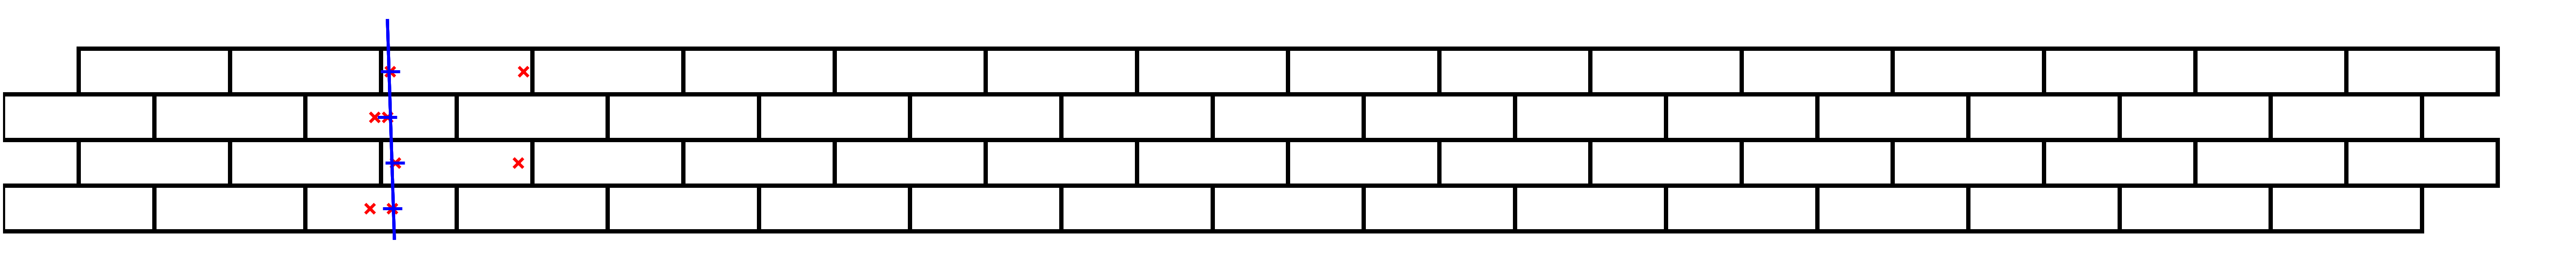

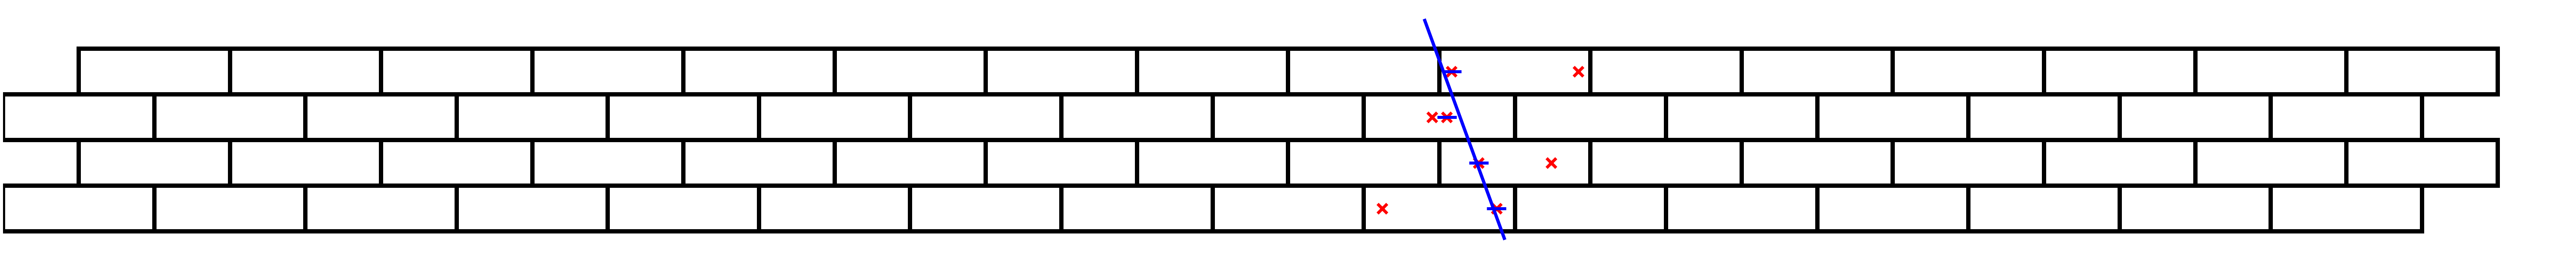

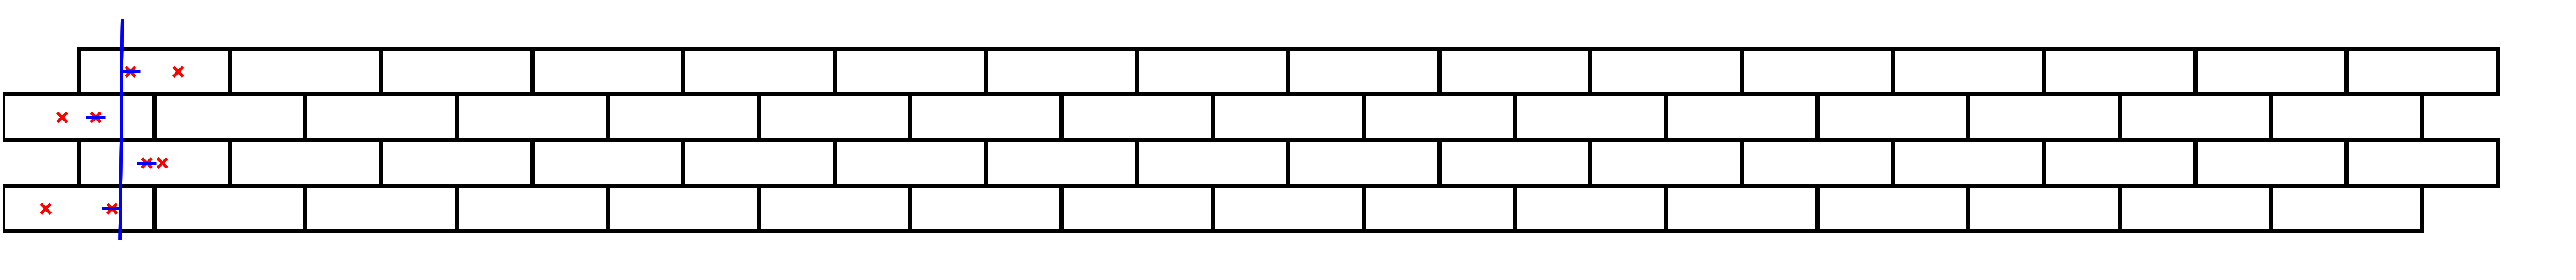

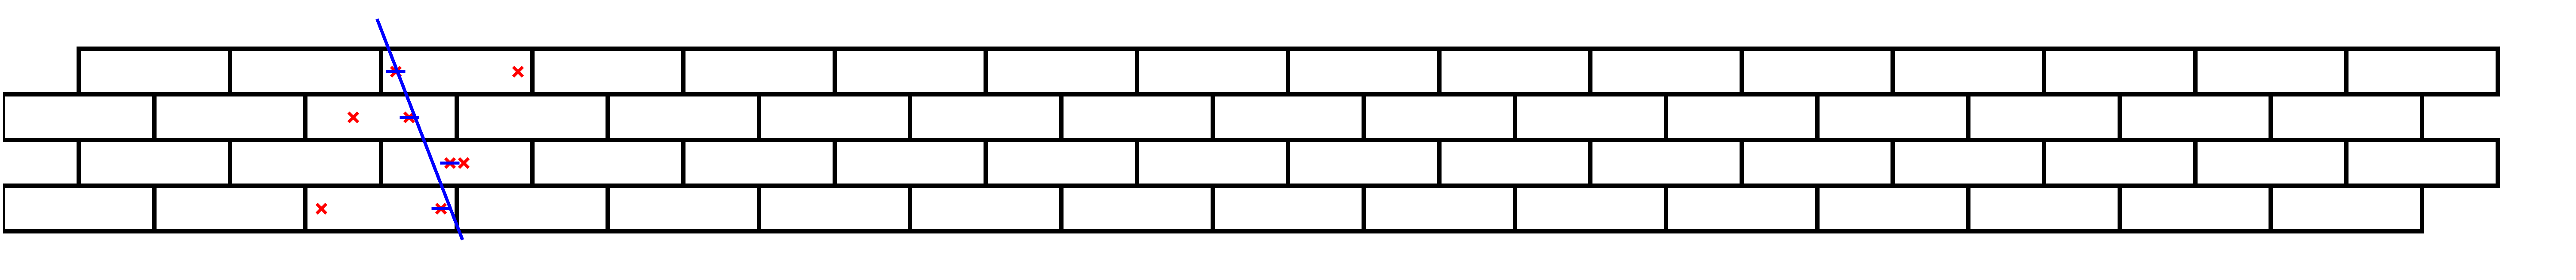

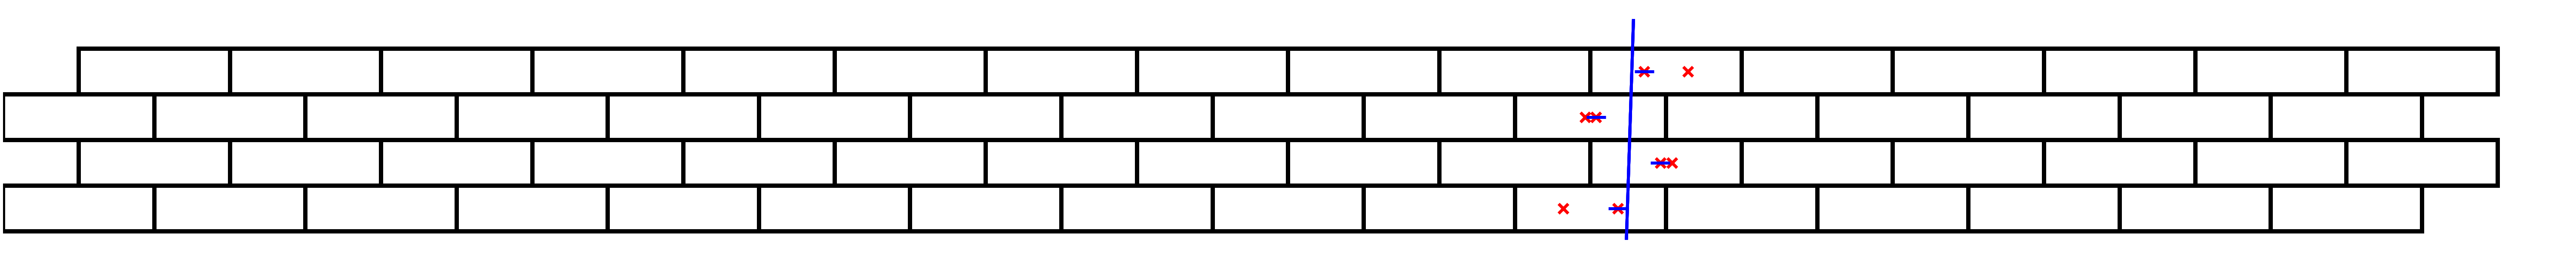

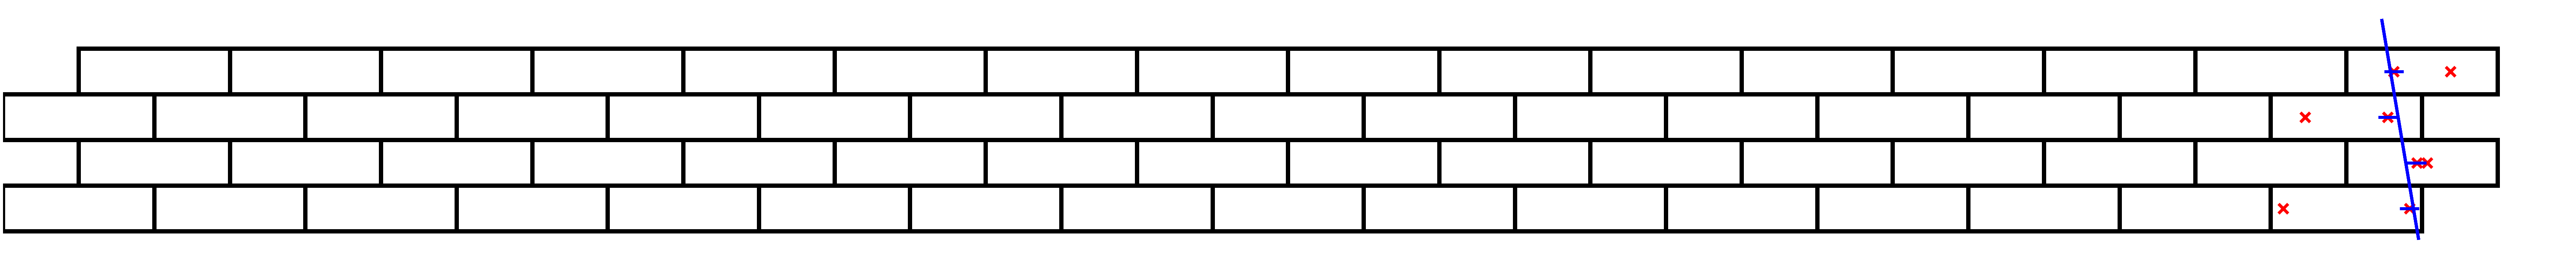

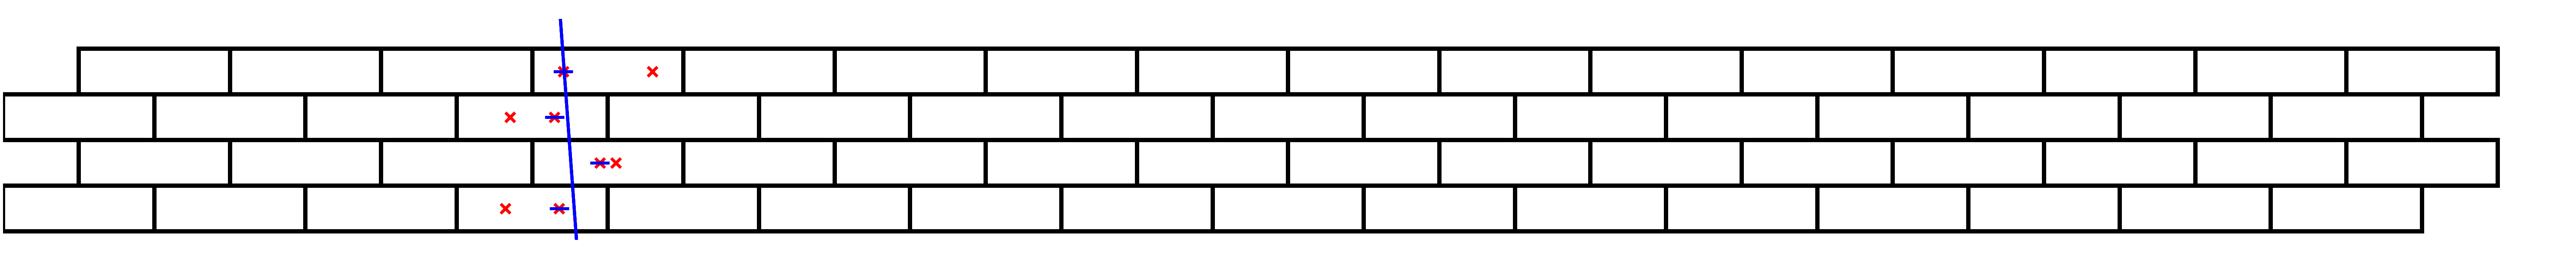

In [11]:
#print("Plotting reconstructed trajectories WITHOUT checking compatibility with experimental error")
for i in np.unique(df2.ORBIT_CNT.values)[:10] :
    try:
        event = df2.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_and_line_plot(event)
    except:
        event = df2.groupby(['ORBIT_CNT']).get_group(i)
        event_and_line_plot(event)

Thanks to the above plot we easily notice that some events are to be discarded because the distance between each line and its points is too big.

## Checking compatibility with experimental error
Each X is determined up to an uncertainty which can be estimated as $\delta x = v_d \delta t$ where $\delta t = 50 \ \text{ns}$. This imposes an extra constraint to the above computations, because even the best possible reconstructed trajectory may still be physically unacceptable; in particular the following holds.   
Due to the fact that $\delta x > 0$ no physically acceptable line will exactly cross each point, but the distance between points and their horizontal projections on the line will be $\leq \delta x$; hence if we can compute this "horizontal distance" and comparing it with $\delta x$ we can discard spurious events.   
Do note that the fraction of events that we need to discard heavily depends on the estimate of $\delta x$, which is in part arbitrary due to the issues related to how we estimate the error on $\delta t$; this will be discussed more in detail at the end of part 3.   


The problem we need to solve now is how to compute this "horizontal distance" between a point and a line; this requires the following equation, not a trivial dot product since this distance is *not* defined via an orthogonal projection. We need to compute the length of the line segment we can construct by projecting our point on the line *moving parallel to the $x$ axis*; we explicitly ignore $y$ because the only meaningful comparison between lengths we can do is along the $x$ axis (since we measure the drift times, which only tell us something about the $x$ coordinates).     
The line segment we construct this way identifies another line, which is parallel to the $x$ axis and intercepts in, say, point $P$ our reconstructed trajectory; the distance we're looking for is therefore the absolute value of the difference between $x_i$ and $x_P$ - where $(x_i,y_i)$ is the point wrt which we're computing the distance to the original line.      


By definition point $P$ is the intersection point between the line $y=y_i$ and line $y=mx+q$; by setting these two $y$ to be equal we trivially obtain that $x_P$ solves the equation $y_i = m x_P + q$. Our distance, hence, is:
$$d_x(P,(x_i,y_i)) = |x_i-x_P| = \Bigg|x_i-\frac{1}{m}(y_i-q)\Bigg| $$    
Notice that this diverges for $m \to 0$, but this is not an issue since it simply means that parallel line meet at infinity (if $m=0$ these two lines are indeed both parallel to the $x$ axis) - which is correct but not relevant, since due to how the muon beam was produced/the detector worked (most sensitive up to 45-50 deg. wrt the vertical) no physically acceptable trajectories can ever be horizontal.   
If $m \to +\infty$ (vertical trajectory) this formula yields $d_x=x_i$ - which once again is the correct result, since when $q = \text{const.}$ and $m$ diverges our line becomes the $y$ axis (i.e. it rotates around the fixed intercept).   
This proves that in any physically relevant case (i.e. when $m\in\mathbb{R}\setminus\{0\}$, $q\in\mathbb{R}$) the obtained equation returns the desired result; hence it suffices to compute the above for each hit in any given event and check that for example the maximum value thus obtained is still in $]0,\delta x[$.

In [12]:
# Experimental uncertainty compatibility check

def exp_unc_compatib_check(event): 
    if (np.abs(event.X_BEST - (event.Y-event.Q)/event.M)).max() < delta_x : #vectorized expression, which computes d_x for every hit in event at the same time and picks the max value
        return event #notice: 2 floats are never exactly equal, so there's no point in slowing this cell down using <= instead of < even if this would be better physically
    else : 
        return None

In [13]:
df3 = df2.groupby(['ORBIT_CNT','EVENT'], group_keys=False)\
                                       .apply(exp_unc_compatib_check)\
                                       .dropna()\
                                       .reset_index()\
                                       .drop(['index'],axis=1) 
print("n. of unique events before:",len(df2.groupby(["ORBIT_CNT","EVENT"]).nunique()))
print("n. of unique events now:",len(df3.groupby(["ORBIT_CNT","EVENT"]).nunique()))
df3

n. of unique events before: 28864
n. of unique events now: 5968


,ORBIT_CNT,LAYER,EVENT,X,COLUMN,XR,XL,Y,X_BEST,M,Q
0,1.897417e+09,1.0,2.0,1.480769,16.0,652.480769,649.519231,6.5,652.480769,19.314286,-12592.666667
1,1.897417e+09,2.0,2.0,18.935897,16.0,690.935897,653.064103,19.5,653.064103,19.314286,-12592.666667
2,1.897417e+09,3.0,2.0,2.064103,16.0,653.064103,648.935897,32.5,653.064103,19.314286,-12592.666667
3,1.897417e+09,4.0,2.0,17.275641,16.0,689.275641,654.724359,45.5,654.724359,19.314286,-12592.666667
4,1.897417e+09,1.0,1.0,3.141026,3.0,108.141026,101.858974,6.5,108.141026,-32.190476,3497.000000
...,...,...,...,...,...,...,...,...,...,...,...
23268,1.920940e+09,4.0,2.0,3.365385,5.0,213.365385,206.634615,45.5,206.634615,27.857143,-5692.125000
23269,1.920940e+09,1.0,1.0,1.480769,5.0,190.480769,187.519231,6.5,190.480769,13.861928,-2638.222488
23270,1.920940e+09,2.0,1.0,16.557692,5.0,226.557692,193.442308,19.5,193.442308,13.861928,-2638.222488
23271,1.920940e+09,3.0,1.0,1.166667,5.0,190.166667,187.833333,32.5,190.166667,13.861928,-2638.222488


We cannot stress enough how heavily this cut depends on $\delta x$ and therefore on the estimate done wrt the drift times uncertainty. The number of `NaN`'s obtained would be smaller with a more generous estimate for $\delta t$; in part 3 we discuss how this value may in a sense be interpreted as an hyperparameter of our model; in any case we notice that we removed more than 90% of the events we previously had, so the estimate used for $\delta t$ is definitively on the stricter side.

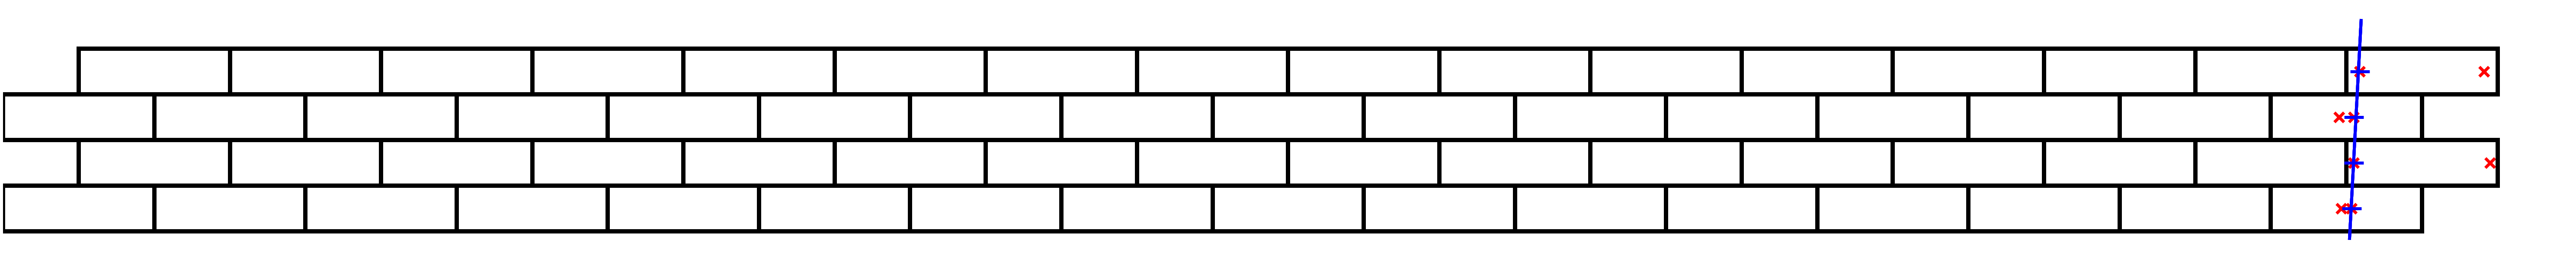

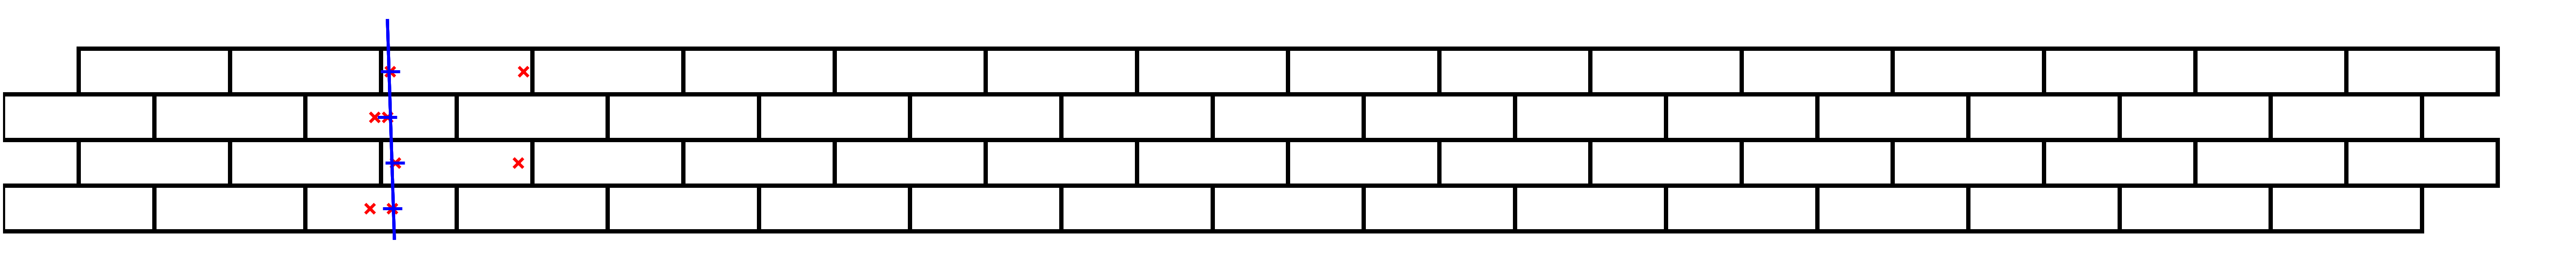

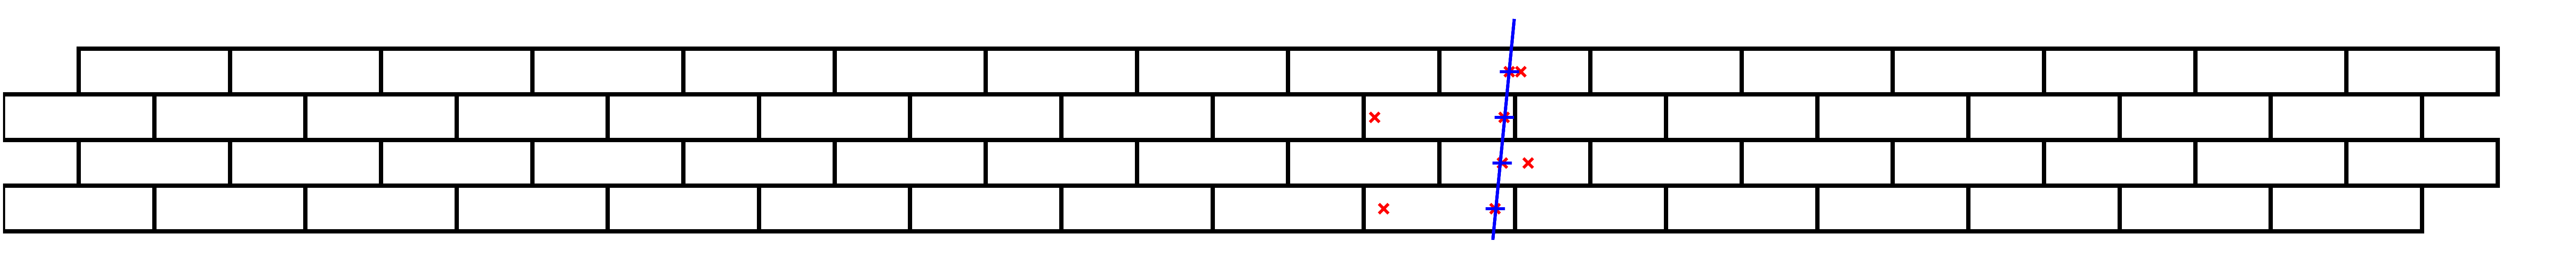

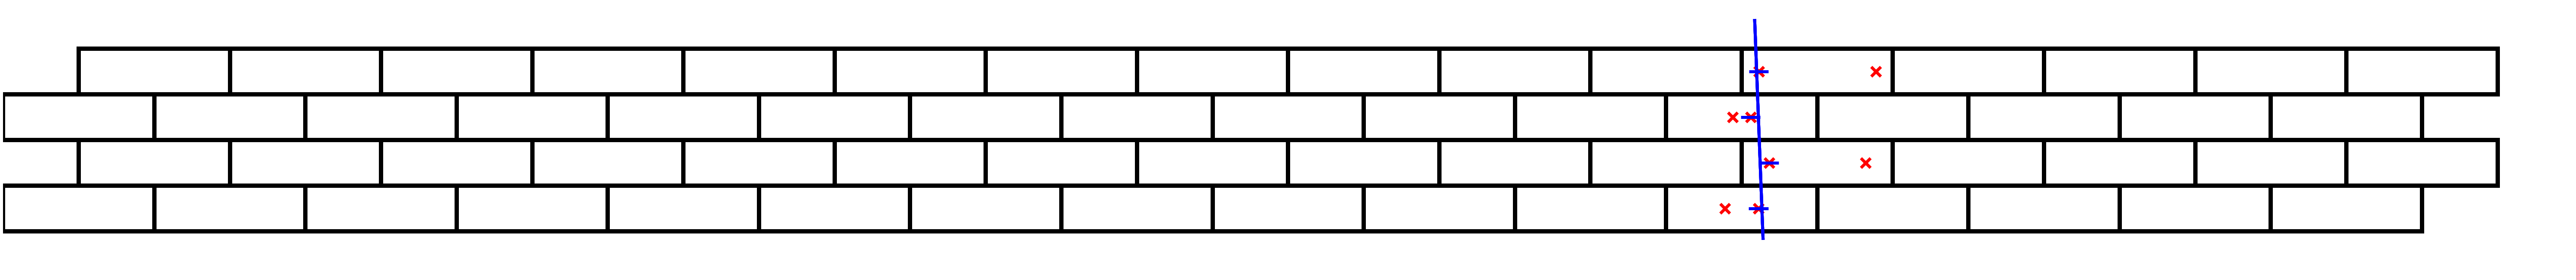

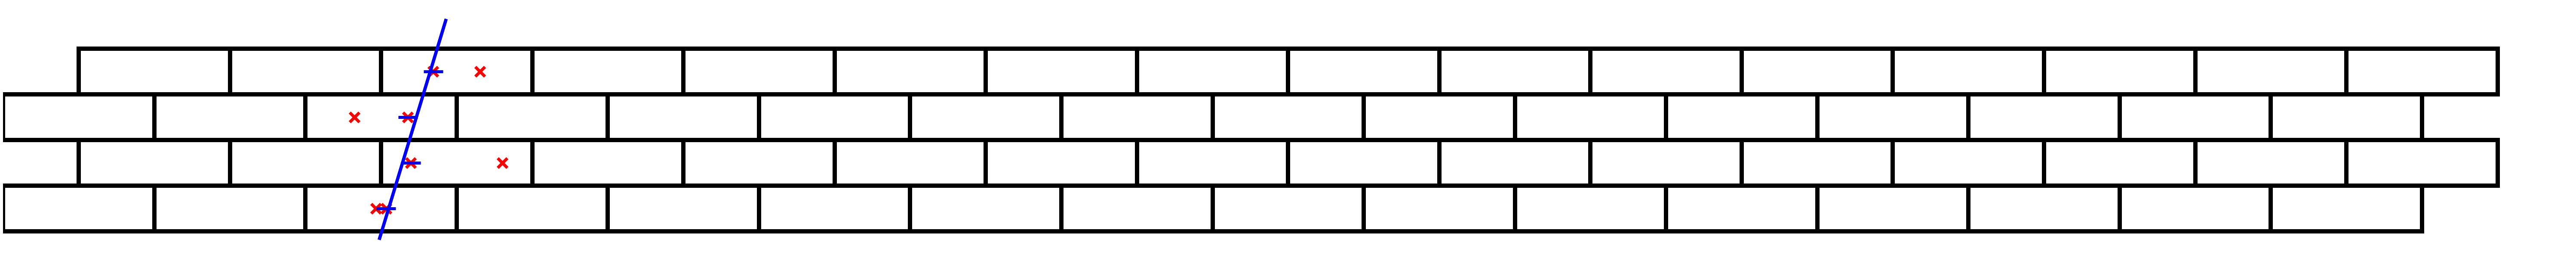

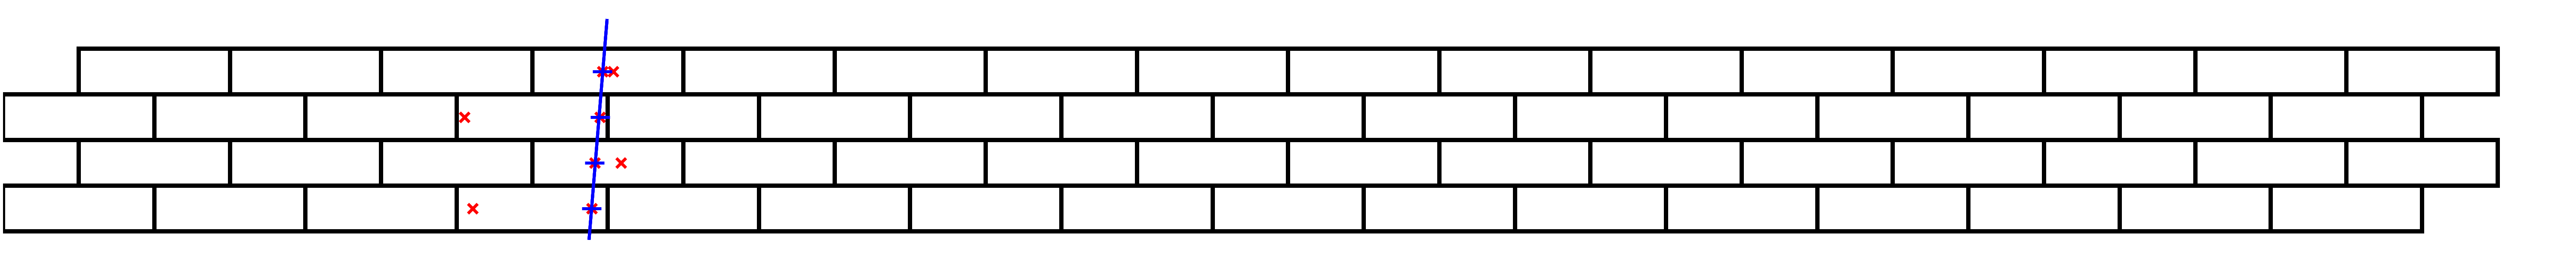

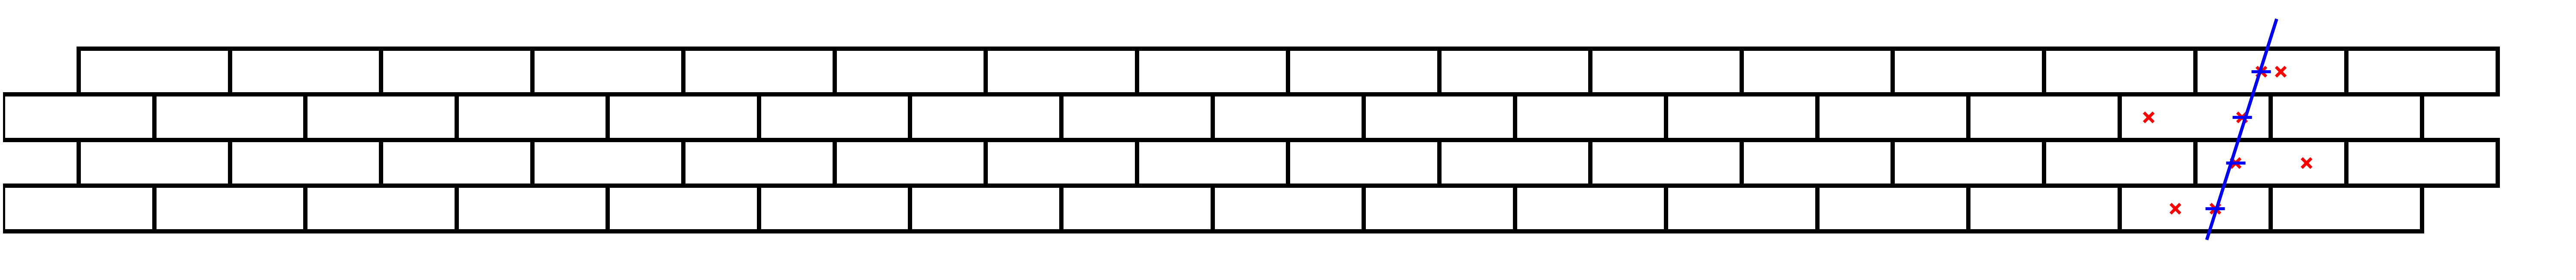

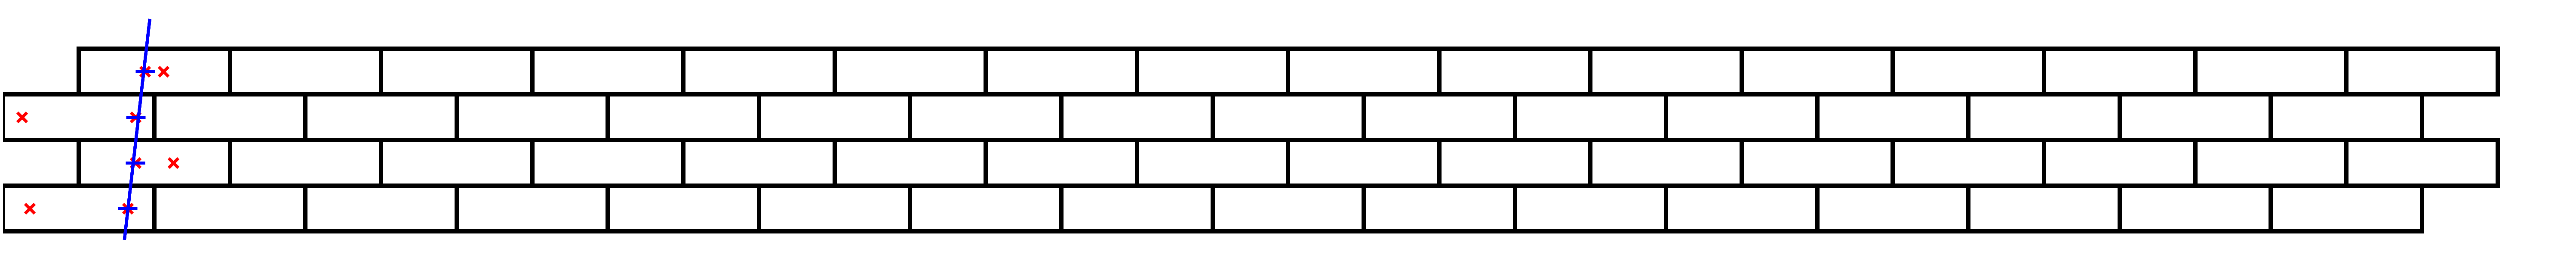

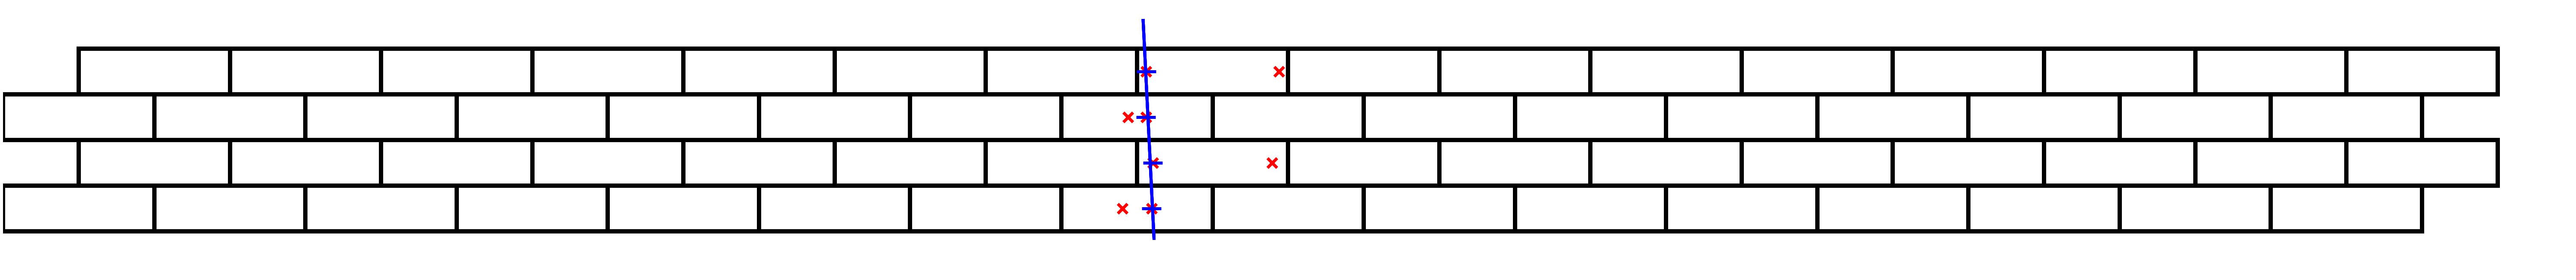

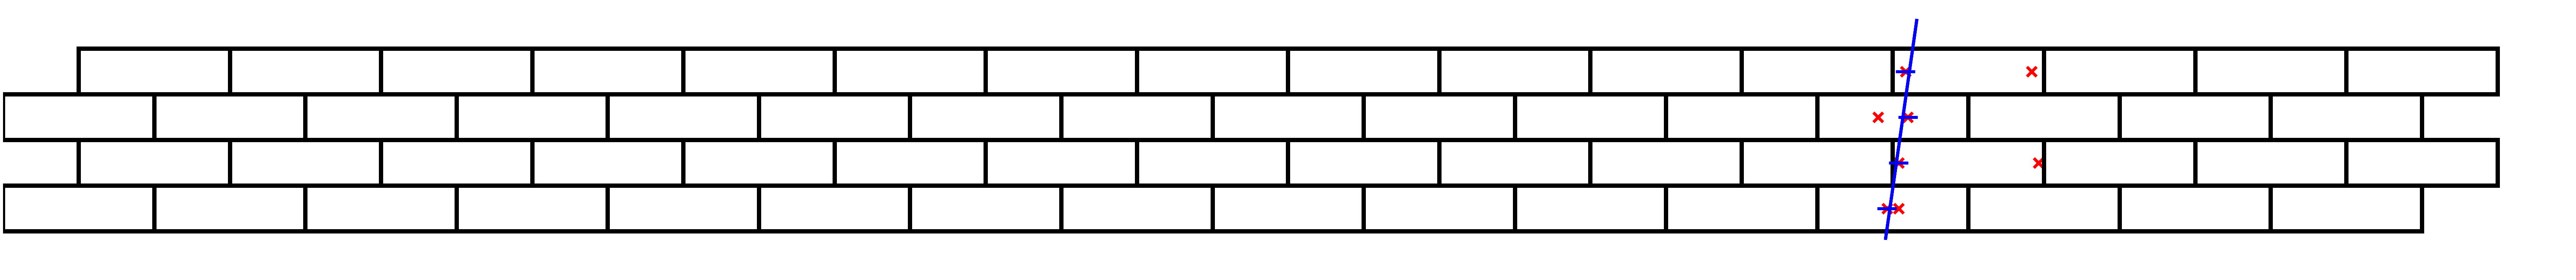

In [14]:
#print("Plotting reconstructed trajectories HAVING CHECKED compatibility with experimental error")
for i in np.unique(df3.ORBIT_CNT.values)[:10] :
    try:
        event = df3.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_and_line_plot(event)
    except:
        event = df3.groupby(['ORBIT_CNT']).get_group(i)
        event_and_line_plot(event)